# Analysis of Graded Agent Responses

This notebook provides comprehensive visualization and analysis of agent response classifications generated by the `grade.py` script. It processes classification results stored in JSONL format and creates detailed visualizations comparing different agent configurations.

## What this notebook does:

### 1. **Data Loading & Processing**
- Automatically discovers and loads classification data from multiple result directories
- Handles both classified data (JSONL files) and raw response data (CSV files) as fallback
- Standardizes data formats across different experiment types

### 2. **Dataset Types Processed**
- **Single-agent results** (`results/`) - Individual model responses
- **Multi-agent results** (`results_multi/`) - Group conversation responses  
- **Multi-agent star topology** (`results_multi_star/`) - Star-pattern conversations
- **Additional experiments** - Any other `results_*` directories found automatically

### 3. **Visualizations Generated**
For each dataset type, the notebook creates:
- Distribution charts of rationale categories used by agents
- Off-topic response analysis (pie charts showing response relevance)
- Answer score distributions (histograms of numeric scores)
- Model-specific performance comparisons
- Cross-topology comparative analysis

### 4. **Advanced Analysis Features**
- Heatmaps showing rationale category usage patterns across topologies
- Statistical comparisons between different agent configurations
- Error analysis and data quality reporting
- Question category breakdowns (when available)

**Data Source Requirements**: The notebook expects classification files generated by `grade.py` to be present in the respective result directories. If classification data is missing, it will attempt to analyze raw CSV response files instead.

**Output**: Interactive Plotly charts, summary statistics tables, and comprehensive data quality reports.

In [1]:
import pandas as pd
import json
import os
import logging
import numpy as np
import glob
from pathlib import Path
import sys

# Add the current directory to sys.path to import analysis functions
sys.path.append(os.path.abspath('.'))

try:
    from analysis_functions import (
        load_datasets_with_fallback,
        prepare_datasets_for_analysis,
        create_combined_dataset,
        generate_summary_stats
    )
except ImportError as e:
    print(f"Error importing analysis functions: {e}")
    print("Make sure analysis_functions.py exists in the current directory")
    raise

# =============================================================================
# CONFIGURATION SECTION
# =============================================================================
# Base directory containing all result folders (results/, results_multi/, etc.)
BASE_DIR = "/Users/ram/Github/wisdom_agents/"

# =============================================================================
# LOGGING SETUP
# =============================================================================
# Configure logging to track data loading progress and any issues
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - NOTEBOOK - %(levelname)s - %(message)s')

# =============================================================================
# DATA LOADING PHASE
# =============================================================================
# Load datasets with automatic fallback from JSONL classification files to raw CSV files
print("=== LOADING DATASETS WITH FALLBACK TO RAW DATA ===")
datasets, dataset_info = load_datasets_with_fallback(BASE_DIR)

# =============================================================================
# DATA PREPARATION PHASE
# =============================================================================
# Standardize data formats and create analysis-ready dataframes
print("\n=== PREPARING DATA FOR ANALYSIS ===")
prepared_datasets = prepare_datasets_for_analysis(datasets, dataset_info)

# Create a combined dataset that merges all individual datasets for comparative analysis
print("\n=== CREATING COMBINED DATASET ===")
prepared_datasets['combined'] = create_combined_dataset(prepared_datasets)

# =============================================================================
# INITIAL DATA SUMMARY
# =============================================================================
# Display summary statistics for each dataset type to understand data availability
print("\n=== DATA PREPARATION SUMMARY ===")

for data_type, data_dict in prepared_datasets.items():
    # Extract the prepared dataframes for this dataset type
    analysis_df = data_dict['analysis']      # Main analysis dataframe with response data
    exploded_df = data_dict['exploded']      # Categories expanded (one row per category)
    errors_df = data_dict['errors']          # Processing errors encountered
    info = data_dict['info']                 # Metadata about the dataset
    
    print(f"\n{data_type.replace('_', '-').title()}:")
    print(f"  Valid responses: {len(analysis_df)}")
    print(f"  Exploded categories: {len(exploded_df)}")
    print(f"  Processing errors: {len(errors_df)}")
    print(f"  Has classification data: {'Yes' if info['has_classification'] else 'No'}")
    print(f"  File type: {info['file_type']}")
    
    if not analysis_df.empty:
        # Display additional metrics when data is available
        print(f"  Unique questions: {analysis_df['question_id'].nunique() if 'question_id' in analysis_df.columns else 'N/A'}")
        
        # Check for model column in various possible formats
        model_col = None
        for col in ['agent_model', 'model_name', 'agent_name']:
            if col in analysis_df.columns:
                model_col = col
                break
        
        if model_col:
            print(f"  Unique models: {analysis_df[model_col].nunique()}")
        
        # Report error types if any processing errors occurred
        if not errors_df.empty and 'error_type' in errors_df.columns:
            print(f"  Error types: {errors_df['error_type'].nunique()}")

Questions already have IDs
=== LOADING DATASETS WITH FALLBACK TO RAW DATA ===

=== PREPARING DATA FOR ANALYSIS ===

=== CREATING COMBINED DATASET ===

=== DATA PREPARATION SUMMARY ===

Results-Ous-Multi:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: unknown

Results-Multi-Star:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: unknown

Results-Ous:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: unknown

Results:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: unknown

Results-Multi:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: unknown

Combined:
  Valid responses: 0
  Exploded categories: 0
  Processing errors: 0
  Has classification data: No
  File type: combined


In [2]:
# =============================================================================
# SUMMARY STATISTICS TABLE GENERATION
# =============================================================================
# Generate a comprehensive summary table showing data availability across all datasets
summary_df = generate_summary_stats(prepared_datasets)

if not summary_df.empty:
    print("=== SUMMARY STATISTICS TABLE ===")
    print(summary_df.to_string(index=False))
    
    # =============================================================================
    # DATA AVAILABILITY ANALYSIS
    # =============================================================================
    # Categorize datasets by data quality and availability
    datasets_with_classification = summary_df[summary_df['Has Classification'] == 'Yes']
    datasets_with_raw_data = summary_df[summary_df['Has Classification'] == 'No']
    
    print(f"\n=== DATA AVAILABILITY SUMMARY ===")
    print(f"Datasets with classification data: {len(datasets_with_classification)}")
    if not datasets_with_classification.empty:
        print("  -", ", ".join(datasets_with_classification['Dataset'].tolist()))
    
    print(f"Datasets with raw data only: {len(datasets_with_raw_data)}")
    if not datasets_with_raw_data.empty:
        print("  -", ", ".join(datasets_with_raw_data['Dataset'].tolist()))
    
    # =============================================================================
    # PREPARE COMBINED DATASETS FOR VISUALIZATION
    # =============================================================================
    # Extract the combined dataframes that will be used for visualization
    df_all = prepared_datasets['combined']['analysis']          # All response data combined
    df_all_exploded = prepared_datasets['combined']['exploded']  # All categories exploded
    df_all_errors = prepared_datasets['combined']['errors']      # All processing errors
    
    print(f"\nCombined dataset: {len(df_all)} total records")
    print(f"Combined exploded categories: {len(df_all_exploded)} records")
    print(f"Combined errors: {len(df_all_errors)} records")
    
    # =============================================================================
    # COLUMN AVAILABILITY DEBUG INFO
    # =============================================================================
    # Display available columns for debugging and understanding data structure
    if not df_all.empty:
        print(f"\nAvailable columns in combined analysis data:")
        # Standard expected columns for basic analysis
        standard_cols = ['question_id', 'agent_name', 'agent_model', 'extracted_answer', 'extracted_answer_numeric', 'is_response_off_topic', 'selected_categories']
        available_standard = [col for col in df_all.columns if col in standard_cols]
        print(f"  Standard columns: {available_standard}")
        
        # Classification-specific columns
        classification_cols = [col for col in df_all.columns if 'classification' in col.lower() or col in ['off_topic_reason', 'error_type']]
        print(f"  Classification columns: {classification_cols}")
else:
    print("No data available for analysis")
    # Initialize empty dataframes if no data is available
    df_all = pd.DataFrame()
    df_all_exploded = pd.DataFrame()
    df_all_errors = pd.DataFrame()

=== SUMMARY STATISTICS TABLE ===
           Dataset Has Classification File Type  Responses  Exploded  Errors
 results_ous_multi                 No   unknown          0         0       0
results_multi_star                 No   unknown          0         0       0
       results_ous                 No   unknown          0         0       0
           results                 No   unknown          0         0       0
     results_multi                 No   unknown          0         0       0
          combined                 No  combined          0         0       0

=== DATA AVAILABILITY SUMMARY ===
Datasets with classification data: 0
Datasets with raw data only: 6
  - results_ous_multi, results_multi_star, results_ous, results, results_multi, combined

Combined dataset: 0 total records
Combined exploded categories: 0 records
Combined errors: 0 records


## Visualization of Graded Rationale Classifications

The following plots visualize the distribution of classified rationale categories, off-topic responses, answer scores, and other metrics. Visualizations are generated for each discovered dataset type:

1. **Single-agent results** - Individual model responses (from `results/`)
2. **Multi-agent results** - Group conversation responses (from `results_multi/`)
3. **Multi-agent star results** - Star topology conversations (from `results_multi_star/`)
4. **Other discovered datasets** - Any additional `results_*` directories
5. **Combined analysis** - Aggregate view across all types

**Note**: Some visualizations may not be available if classification data is missing. In such cases, basic statistics will be shown instead.

**Updated**: The visualization functions now handle standardized data formats and improved category processing.

## Visualization Section: Detailed Analysis Charts

This section generates comprehensive visualizations for each discovered dataset type. The charts provide insights into agent behavior patterns, response quality, and rationale classification distributions.

### Chart Types Generated:

#### 1. **Rationale Category Distribution Charts**
- **Purpose**: Shows which reasoning categories agents use most frequently
- **Data Source**: Exploded classification data with individual category instances
- **Chart Type**: Bar charts showing frequency counts for each rationale type

#### 2. **Off-Topic Response Analysis**
- **Purpose**: Identifies how often agents provide irrelevant or off-topic responses
- **Data Source**: Classification flags indicating response relevance
- **Chart Type**: Pie charts showing proportions of on-topic vs off-topic responses

#### 3. **Answer Score Distributions**
- **Purpose**: Analyzes the numeric quality scores assigned to agent responses
- **Data Source**: Extracted numeric scores from response evaluations
- **Chart Type**: Histograms showing the distribution of scores (typically 1-7 scale)

#### 4. **Model Performance Comparisons**
- **Purpose**: Compares how different AI models perform across rationale categories
- **Data Source**: Grouped data by agent model and category usage
- **Chart Type**: Grouped bar charts showing category usage by model type

#### 5. **Question-Specific Analysis**
- **Purpose**: Shows average performance across different question IDs
- **Data Source**: Aggregated scores grouped by individual questions
- **Chart Type**: Bar charts with average scores per question

### Dataset Coverage:
- **Single-agent**: Individual model responses without collaboration
- **Multi-agent**: Group conversations with multiple agents collaborating
- **Star topology**: Hub-and-spoke conversation patterns
- **Combined analysis**: Aggregate view across all experiment types

**Note**: If classification data is unavailable, the notebook displays informative messages and attempts analysis using available raw data.

**Interactivity**: All charts are generated using Plotly for interactive exploration (zoom, hover details, etc.)

In [3]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme for seaborn plots to ensure consistent styling
sns.set_theme(style="whitegrid")

# =============================================================================
# VISUALIZATION FUNCTION DEFINITIONS
# =============================================================================
# These functions create standardized charts for different aspects of the data

def plot_category_distribution(df_exploded, title_prefix=""):
    """
    Create a bar chart showing the frequency of each rationale category.
    
    Args:
        df_exploded: DataFrame with one row per category instance
        title_prefix: String to prepend to chart title (e.g., "Single-Agent -")
    
    Returns:
        Plotly figure object or None if no data available
    """
    if df_exploded.empty or 'selected_categories' not in df_exploded.columns:
        print(f"No data available for category distribution: {title_prefix}")
        return None
    
    # Filter to only valid (non-null) categories
    valid_categories = df_exploded[df_exploded['selected_categories'].notna()]
    if valid_categories.empty:
        print(f"No valid categories found: {title_prefix}")
        return None
    
    # Count frequency of each category and prepare for plotting
    category_counts = valid_categories['selected_categories'].value_counts().reset_index()
    category_counts.columns = ['category', 'count']
    
    # Create interactive bar chart
    fig = px.bar(category_counts, x='category', y='count',
                 title=f'{title_prefix} Distribution of Selected Rationale Categories',
                 labels={'category': 'Rationale Category', 'count': 'Frequency'},
                 height=600)
    fig.update_layout(xaxis_tickangle=-45)  # Rotate labels for readability
    return fig

def plot_off_topic_distribution(df_analysis, title_prefix=""):
    """
    Create a pie chart showing the proportion of on-topic vs off-topic responses.
    
    Args:
        df_analysis: Main analysis DataFrame with off-topic flags
        title_prefix: String to prepend to chart title
    
    Returns:
        Plotly figure object or None if no data available
    """
    if df_analysis.empty or 'is_response_off_topic' not in df_analysis.columns:
        print(f"No off-topic data available: {title_prefix}")
        return None
    
    # Count on-topic vs off-topic responses (including null values)
    off_topic_counts = df_analysis['is_response_off_topic'].value_counts(dropna=False).reset_index()
    off_topic_counts.columns = ['is_off_topic', 'count']
    
    # Create interactive pie chart with hole in center (donut chart)
    fig = px.pie(off_topic_counts, names='is_off_topic', values='count',
                 title=f'{title_prefix} Distribution of Off-Topic Responses',
                 hole=0.3)
    return fig

def plot_answer_distribution(df_analysis, title_prefix=""):
    """
    Create a histogram showing the distribution of numeric answer scores.
    
    Args:
        df_analysis: Main analysis DataFrame with numeric scores
        title_prefix: String to prepend to chart title
    
    Returns:
        Plotly figure object or None if no data available
    """
    if df_analysis.empty or 'extracted_answer_numeric' not in df_analysis.columns:
        print(f"No answer score data available: {title_prefix}")
        return None
    
    # Filter to only valid (non-null) numeric answers
    valid_answers = df_analysis[df_analysis['extracted_answer_numeric'].notna()]
    if valid_answers.empty:
        print(f"No valid answer scores found: {title_prefix}")
        return None
    
    # Create histogram with 7 bins (typically for 1-7 rating scale)
    fig = px.histogram(valid_answers, x='extracted_answer_numeric',
                       title=f'{title_prefix} Distribution of Answer Scores',
                       labels={'extracted_answer_numeric': 'Answer Score'},
                       nbins=7)
    return fig

def plot_categories_by_model(df_exploded, title_prefix=""):
    """
    Create a grouped bar chart comparing category usage across different AI models.
    
    Args:
        df_exploded: DataFrame with exploded categories and model information
        title_prefix: String to prepend to chart title
    
    Returns:
        Plotly figure object or None if no data available
    """
    if (df_exploded.empty or 'agent_model' not in df_exploded.columns or 
        'selected_categories' not in df_exploded.columns):
        print(f"No model/category data available: {title_prefix}")
        return None
    
    # Filter to valid data only
    valid_data = df_exploded[df_exploded['selected_categories'].notna()]
    if valid_data.empty:
        print(f"No valid model/category data found: {title_prefix}")
        return None
    
    # Group by model and category to get counts
    categories_by_model = valid_data.groupby(['agent_model', 'selected_categories']).size().reset_index(name='count')
    
    if categories_by_model.empty:
        print(f"No aggregated model/category data: {title_prefix}")
        return None
    
    # Create grouped bar chart with different colors for each model
    fig = px.bar(categories_by_model, x='selected_categories', y='count',
                 color='agent_model', barmode='group',
                 title=f'{title_prefix} Rationale Categories by Agent Model',
                 labels={'selected_categories': 'Rationale Category', 'count': 'Frequency'},
                 height=700)
    fig.update_layout(xaxis_tickangle=-45)  # Rotate labels for readability
    return fig

# =============================================================================
# GENERATE VISUALIZATIONS FOR EACH DATASET TYPE
# =============================================================================
# Create comprehensive visualizations for each discovered dataset

for data_type, data_dict in prepared_datasets.items():
    # Extract dataframes for this dataset type
    analysis_df = data_dict['analysis']
    exploded_df = data_dict['exploded']
    
    # Skip if no data is available for this dataset type
    if analysis_df.empty:
        print(f"\n=== {data_type.replace('_', ' ').upper()} VISUALIZATIONS ===")
        print(f"No data available for {data_type} visualizations")
        continue
    
    # Format dataset name for display
    dataset_name = data_type.replace('_', '-').title()
    print(f"\n=== {dataset_name.upper()} VISUALIZATIONS ===")
    
    # Generate visualization 1: Distribution of rationale categories
    fig = plot_category_distribution(exploded_df, f"{dataset_name} -")
    if fig:
        fig.show()
    
    # Generate visualization 2: Proportion of off-topic responses
    fig = plot_off_topic_distribution(analysis_df, f"{dataset_name} -")
    if fig:
        fig.show()
    
    # Generate visualization 3: Distribution of answer quality scores
    fig = plot_answer_distribution(analysis_df, f"{dataset_name} -")
    if fig:
        fig.show()
    
    # Generate visualization 4: Category usage comparison across models
    fig = plot_categories_by_model(exploded_df, f"{dataset_name} -")
    if fig:
        fig.show()
    
    # Generate visualization 5: Average answer scores by individual questions
    if ('extracted_answer_numeric' in analysis_df.columns and 
        'question_id' in analysis_df.columns and
        analysis_df['extracted_answer_numeric'].notna().any()):
        
        # Calculate average score for each question
        avg_answer_by_qid = analysis_df.groupby('question_id')['extracted_answer_numeric'].mean().reset_index()
        if not avg_answer_by_qid.empty:
            fig = px.bar(avg_answer_by_qid, x='question_id', y='extracted_answer_numeric',
                        title=f'{dataset_name} - Average Answer Score by Question ID',
                        labels={'question_id': 'Question ID', 'extracted_answer_numeric': 'Average Answer Score'})
            fig.update_layout(xaxis_type='category')  # Treat question IDs as categories
            fig.show()


=== RESULTS OUS MULTI VISUALIZATIONS ===
No data available for results_ous_multi visualizations

=== RESULTS MULTI STAR VISUALIZATIONS ===
No data available for results_multi_star visualizations

=== RESULTS OUS VISUALIZATIONS ===
No data available for results_ous visualizations

=== RESULTS VISUALIZATIONS ===
No data available for results visualizations

=== RESULTS MULTI VISUALIZATIONS ===
No data available for results_multi visualizations

=== COMBINED VISUALIZATIONS ===
No data available for combined visualizations


In [4]:
# =============================================================================
# COMPARATIVE ANALYSIS BETWEEN DATASET TYPES
# =============================================================================
# This section creates side-by-side comparisons between different experiment types
# (single-agent vs multi-agent vs star topology, etc.)

print("\n=== COMPARATIVE ANALYSIS ===")

# Filter out the 'combined' dataset for comparison (we'll show it separately)
# We want to compare individual dataset types, not the combined aggregation
comparison_datasets = {k: v for k, v in prepared_datasets.items() if k != 'combined'}

if len(comparison_datasets) >= 2:
    print(f"Comparing {len(comparison_datasets)} dataset types")
    
    # =============================================================================
    # COMPARISON 1: SIDE-BY-SIDE CATEGORY DISTRIBUTION
    # =============================================================================
    # Create subplots showing category distributions for each dataset type
    
    # Filter to datasets that have valid exploded category data
    valid_exploded_datasets = {k: v['exploded'] for k, v in comparison_datasets.items() 
                              if not v['exploded'].empty and 'selected_categories' in v['exploded'].columns}
    
    if len(valid_exploded_datasets) >= 2:
        print("\n1. Category Distribution Comparison")
        
        # Calculate grid layout for subplots (max 3 columns)
        n_datasets = len(valid_exploded_datasets)
        cols = min(3, n_datasets)  # Maximum 3 columns for readability
        rows = (n_datasets + cols - 1) // cols  # Calculate needed rows
        
        # Create subplot grid with individual bar charts
        fig = make_subplots(
            rows=rows, cols=cols,
            subplot_titles=[k.replace('_', '-').title() for k in valid_exploded_datasets.keys()],
            specs=[[{"type": "bar"} for _ in range(cols)] for _ in range(rows)]
        )
        
        # Add data for each dataset type to its subplot
        for i, (data_type, exploded_df) in enumerate(valid_exploded_datasets.items()):
            row = (i // cols) + 1
            col = (i % cols) + 1
            
            # Get top 10 categories for this dataset (to avoid overcrowding)
            category_counts = exploded_df['selected_categories'].value_counts().head(10)
            
            fig.add_trace(
                go.Bar(x=category_counts.index, y=category_counts.values, 
                      name=data_type.replace('_', '-').title()),
                row=row, col=col
            )
        
        # Update layout and display
        fig.update_layout(
            title_text="Top 10 Rationale Categories by Dataset Type",
            height=400 * rows,
            showlegend=False  # Hide legend since subplot titles show dataset names
        )
        fig.update_xaxes(tickangle=-45)  # Rotate x-axis labels
        fig.show()
    
    # =============================================================================
    # COMPARISON 2: ANSWER SCORE DISTRIBUTION COMPARISON
    # =============================================================================
    # Create box plots comparing answer score distributions across dataset types
    
    valid_analysis_datasets = {k: v['analysis'] for k, v in comparison_datasets.items() 
                              if not v['analysis'].empty and 'extracted_answer_numeric' in v['analysis'].columns}
    
    if len(valid_analysis_datasets) >= 2:
        print("\n2. Answer Score Distribution Comparison")
        
        # Combine data from all datasets for comparison
        comparison_data = []
        for data_type, analysis_df in valid_analysis_datasets.items():
            scores = analysis_df[analysis_df['extracted_answer_numeric'].notna()]
            for score in scores['extracted_answer_numeric']:
                comparison_data.append({
                    'score': score, 
                    'dataset_type': data_type.replace('_', '-').title()
                })
        
        if comparison_data:
            comparison_df = pd.DataFrame(comparison_data)
            
            # Create box plot showing distribution differences
            fig = px.box(comparison_df, x='dataset_type', y='score',
                        title='Answer Score Distribution by Dataset Type',
                        labels={'dataset_type': 'Dataset Type', 'score': 'Answer Score'})
            fig.show()
    
    # =============================================================================
    # COMPARISON 3: OFF-TOPIC RESPONSE RATE COMPARISON
    # =============================================================================
    # Calculate and compare the percentage of off-topic responses across dataset types
    
    print("\n3. Off-topic Response Rate Comparison")
    
    off_topic_comparison_data = []
    for data_type, data_dict in comparison_datasets.items():
        analysis_df = data_dict['analysis']
        if not analysis_df.empty and 'is_response_off_topic' in analysis_df.columns:
            # Calculate percentage of off-topic responses
            off_topic_rate = (analysis_df['is_response_off_topic'].sum() / len(analysis_df)) * 100
            off_topic_comparison_data.append({
                'dataset_type': data_type.replace('_', '-').title(),
                'off_topic_rate': off_topic_rate,
                'total_responses': len(analysis_df)
            })
    
    if off_topic_comparison_data:
        off_topic_df = pd.DataFrame(off_topic_comparison_data)
        
        # Create bar chart with response counts as text labels
        fig = px.bar(off_topic_df, x='dataset_type', y='off_topic_rate',
                    title='Off-Topic Response Rates by Dataset Type (%)',
                    labels={'dataset_type': 'Dataset Type', 'off_topic_rate': 'Off-Topic Rate (%)'},
                    text='total_responses'  # Show sample size on bars
                   )
        fig.update_traces(texttemplate='n=%{text}', textposition="outside")
        fig.show()
    
    # =============================================================================
    # COMPARISON 4: MODEL PERFORMANCE ACROSS DATASET TYPES
    # =============================================================================
    # Compare how the same models perform in different experimental setups
    
    print("\n4. Model Performance Comparison")
    
    model_performance_data = []
    for data_type, data_dict in comparison_datasets.items():
        analysis_df = data_dict['analysis']
        if (not analysis_df.empty and 'agent_model' in analysis_df.columns and 
            'extracted_answer_numeric' in analysis_df.columns):
            
            # Calculate average performance per model for this dataset
            model_perf = analysis_df.groupby('agent_model')['extracted_answer_numeric'].agg(['mean', 'count']).reset_index()
            model_perf['dataset_type'] = data_type.replace('_', '-').title()
            model_performance_data.append(model_perf)
    
    if model_performance_data:
        combined_model_perf = pd.concat(model_performance_data, ignore_index=True)
        
        # Filter to models that appear in multiple datasets (for meaningful comparison)
        model_counts = combined_model_perf['agent_model'].value_counts()
        common_models = model_counts[model_counts > 1].index
        
        if len(common_models) > 0:
            filtered_perf = combined_model_perf[combined_model_perf['agent_model'].isin(common_models)]
            
            # Create grouped bar chart with sample sizes as text
            fig = px.bar(filtered_perf, x='agent_model', y='mean',
                        color='dataset_type', barmode='group',
                        title='Average Answer Score by Model and Dataset Type',
                        labels={'agent_model': 'Agent Model', 'mean': 'Average Answer Score'},
                        text='count')  # Show sample size for each bar
            fig.update_traces(texttemplate='n=%{text}', textposition="outside")
            fig.update_layout(xaxis_tickangle=-45)
            fig.show()

else:
    print("Not enough datasets for comparative analysis (need at least 2 non-empty datasets)")

print("\n=== ANALYSIS COMPLETE ===")


=== COMPARATIVE ANALYSIS ===
Comparing 5 dataset types

3. Off-topic Response Rate Comparison

4. Model Performance Comparison

=== ANALYSIS COMPLETE ===


In [5]:
# =============================================================================
# COMPREHENSIVE SUMMARY STATISTICS TABLE
# =============================================================================
# Generate and display a final summary table with all key metrics

print("=== COMPREHENSIVE SUMMARY STATISTICS ===")

summary_df = generate_summary_stats(prepared_datasets)

if not summary_df.empty:
    print("\nDetailed Summary Statistics:")
    print(summary_df.to_string(index=False))
    
    # Create an interactive table using Plotly if available
    try:
        import plotly.graph_objects as go
        
        fig = go.Figure(data=[go.Table(
            header=dict(values=list(summary_df.columns),
                       fill_color='paleturquoise',
                       align='left'),
            cells=dict(values=[summary_df[col] for col in summary_df.columns],
                      fill_color='lavender',
                      align='left'))
        ])
        fig.update_layout(title="Summary Statistics: Multi-Dataset Analysis with Improved Data Handling")
        fig.show()
    except ImportError:
        print("Plotly not available, summary table shown above")

# =============================================================================
# ERROR ANALYSIS SECTION
# =============================================================================
# Analyze and visualize any processing errors encountered during data loading

# Combine errors from all datasets for comprehensive error analysis
all_errors = []
for data_type, data_dict in prepared_datasets.items():
    errors_df = data_dict['errors']
    if not errors_df.empty:
        errors_df = errors_df.copy()
        errors_df['source_dataset'] = data_type.replace('_', '-').title()
        all_errors.append(errors_df)

if all_errors:
    combined_errors = pd.concat(all_errors, ignore_index=True)
    
    print("\n=== ERROR ANALYSIS ===")
    if 'error_type' in combined_errors.columns:
        # Group errors by type and source dataset
        error_by_type = combined_errors.groupby(['source_dataset', 'error_type']).size().reset_index(name='count')
        
        if not error_by_type.empty:
            # Create visualization of error patterns
            try:
                import plotly.express as px
                fig = px.bar(error_by_type, x='error_type', y='count', color='source_dataset',
                            title='Processing Errors by Type and Dataset',
                            labels={'error_type': 'Error Type', 'count': 'Count'},
                            barmode='group')
                fig.update_layout(xaxis_tickangle=-45)
                fig.show()
            except ImportError:
                print("Plotly not available for error visualization")
            
            # Create a summary table of errors
            print("Error summary by dataset:")
            try:
                error_pivot = error_by_type.pivot(index='error_type', columns='source_dataset', values='count').fillna(0)
                print(error_pivot)
            except Exception as e:
                print(f"Could not create error pivot table: {e}")
                print(error_by_type)
else:
    print("\n=== NO PROCESSING ERRORS FOUND ===")

# =============================================================================
# DATA QUALITY REPORT
# =============================================================================
# Provide a comprehensive report on data quality and completeness

print("\n=== DATA QUALITY REPORT ===")
for data_type, data_dict in prepared_datasets.items():
    if data_type != 'combined':  # Skip the combined dataset in individual reports
        info = data_dict['info']
        analysis_df = data_dict['analysis']
        exploded_df = data_dict['exploded']
        
        # Determine data availability status with visual indicators
        if info['has_classification']:
            status = "✓ Classification data"  # Full classification data available
        elif not analysis_df.empty:
            status = "○ Raw data only"        # Only raw response data available
        else:
            status = "✗ No data"              # No usable data found
            
        print(f"\n{data_type}:")
        print(f"  Status: {status}")
        print(f"  Files processed: {info['file_count']}")
        print(f"  File type: {info['file_type']}")
        
        if not analysis_df.empty:
            # Assess data completeness for key columns
            key_columns = ['question_id', 'agent_name', 'extracted_answer']
            missing_data = {}
            for col in key_columns:
                if col in analysis_df.columns:
                    missing_count = analysis_df[col].isna().sum()
                    missing_pct = (missing_count / len(analysis_df)) * 100
                    missing_data[col] = f"{missing_count} ({missing_pct:.1f}%)"
                else:
                    missing_data[col] = "Column missing"
            
            print(f"  Missing data: {missing_data}")
            
            # Calculate category richness if classification data is available
            if info['has_classification'] and not exploded_df.empty:
                avg_categories = len(exploded_df) / len(analysis_df)
                print(f"  Categories per response: {avg_categories:.1f} avg")

# =============================================================================
# FINAL EXECUTION SUMMARY
# =============================================================================
# Provide a final summary of what was processed and analyzed

print("\nNotebook execution complete!")
print("\nData Sources Summary:")
for data_type, data_dict in prepared_datasets.items():
    if data_type != 'combined':
        info = data_dict['info']
        analysis_df = data_dict['analysis']
        
        # Status indicators for quick reference
        if info['has_classification']:
            status = "✓ Classification data"
        elif not analysis_df.empty:
            status = "○ Raw data only"
        else:
            status = "✗ No data"
            
        print(f"  {data_type}: {status} ({info['file_count']} files)")

=== COMPREHENSIVE SUMMARY STATISTICS ===

Detailed Summary Statistics:
           Dataset Has Classification File Type  Responses  Exploded  Errors
 results_ous_multi                 No   unknown          0         0       0
results_multi_star                 No   unknown          0         0       0
       results_ous                 No   unknown          0         0       0
           results                 No   unknown          0         0       0
     results_multi                 No   unknown          0         0       0
          combined                 No  combined          0         0       0



=== NO PROCESSING ERRORS FOUND ===

=== DATA QUALITY REPORT ===

results_ous_multi:
  Status: ✗ No data
  Files processed: 38
  File type: unknown

results_multi_star:
  Status: ✗ No data
  Files processed: 3
  File type: unknown

results_ous:
  Status: ✗ No data
  Files processed: 12
  File type: unknown

results:
  Status: ✗ No data
  Files processed: 15
  File type: unknown

results_multi:
  Status: ✗ No data
  Files processed: 14
  File type: unknown

Notebook execution complete!

Data Sources Summary:
  results_ous_multi: ✗ No data (38 files)
  results_multi_star: ✗ No data (3 files)
  results_ous: ✗ No data (12 files)
  results: ✗ No data (15 files)
  results_multi: ✗ No data (14 files)


2025-05-23 17:14:38,824 - NOTEBOOK - INFO - HTTP Request: GET https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json "HTTP/1.1 200 OK"


Found 1 question categories: ['All Questions']
Found 3 topologies: ['Single-Agent', 'Multi-Agent', 'Star-Topology']
Total classification records: 447374
Valid rationale categories found: 26
Response totals by topology: {'Multi-Agent': 362755, 'Single-Agent': 15650, 'Star-Topology': 68969}


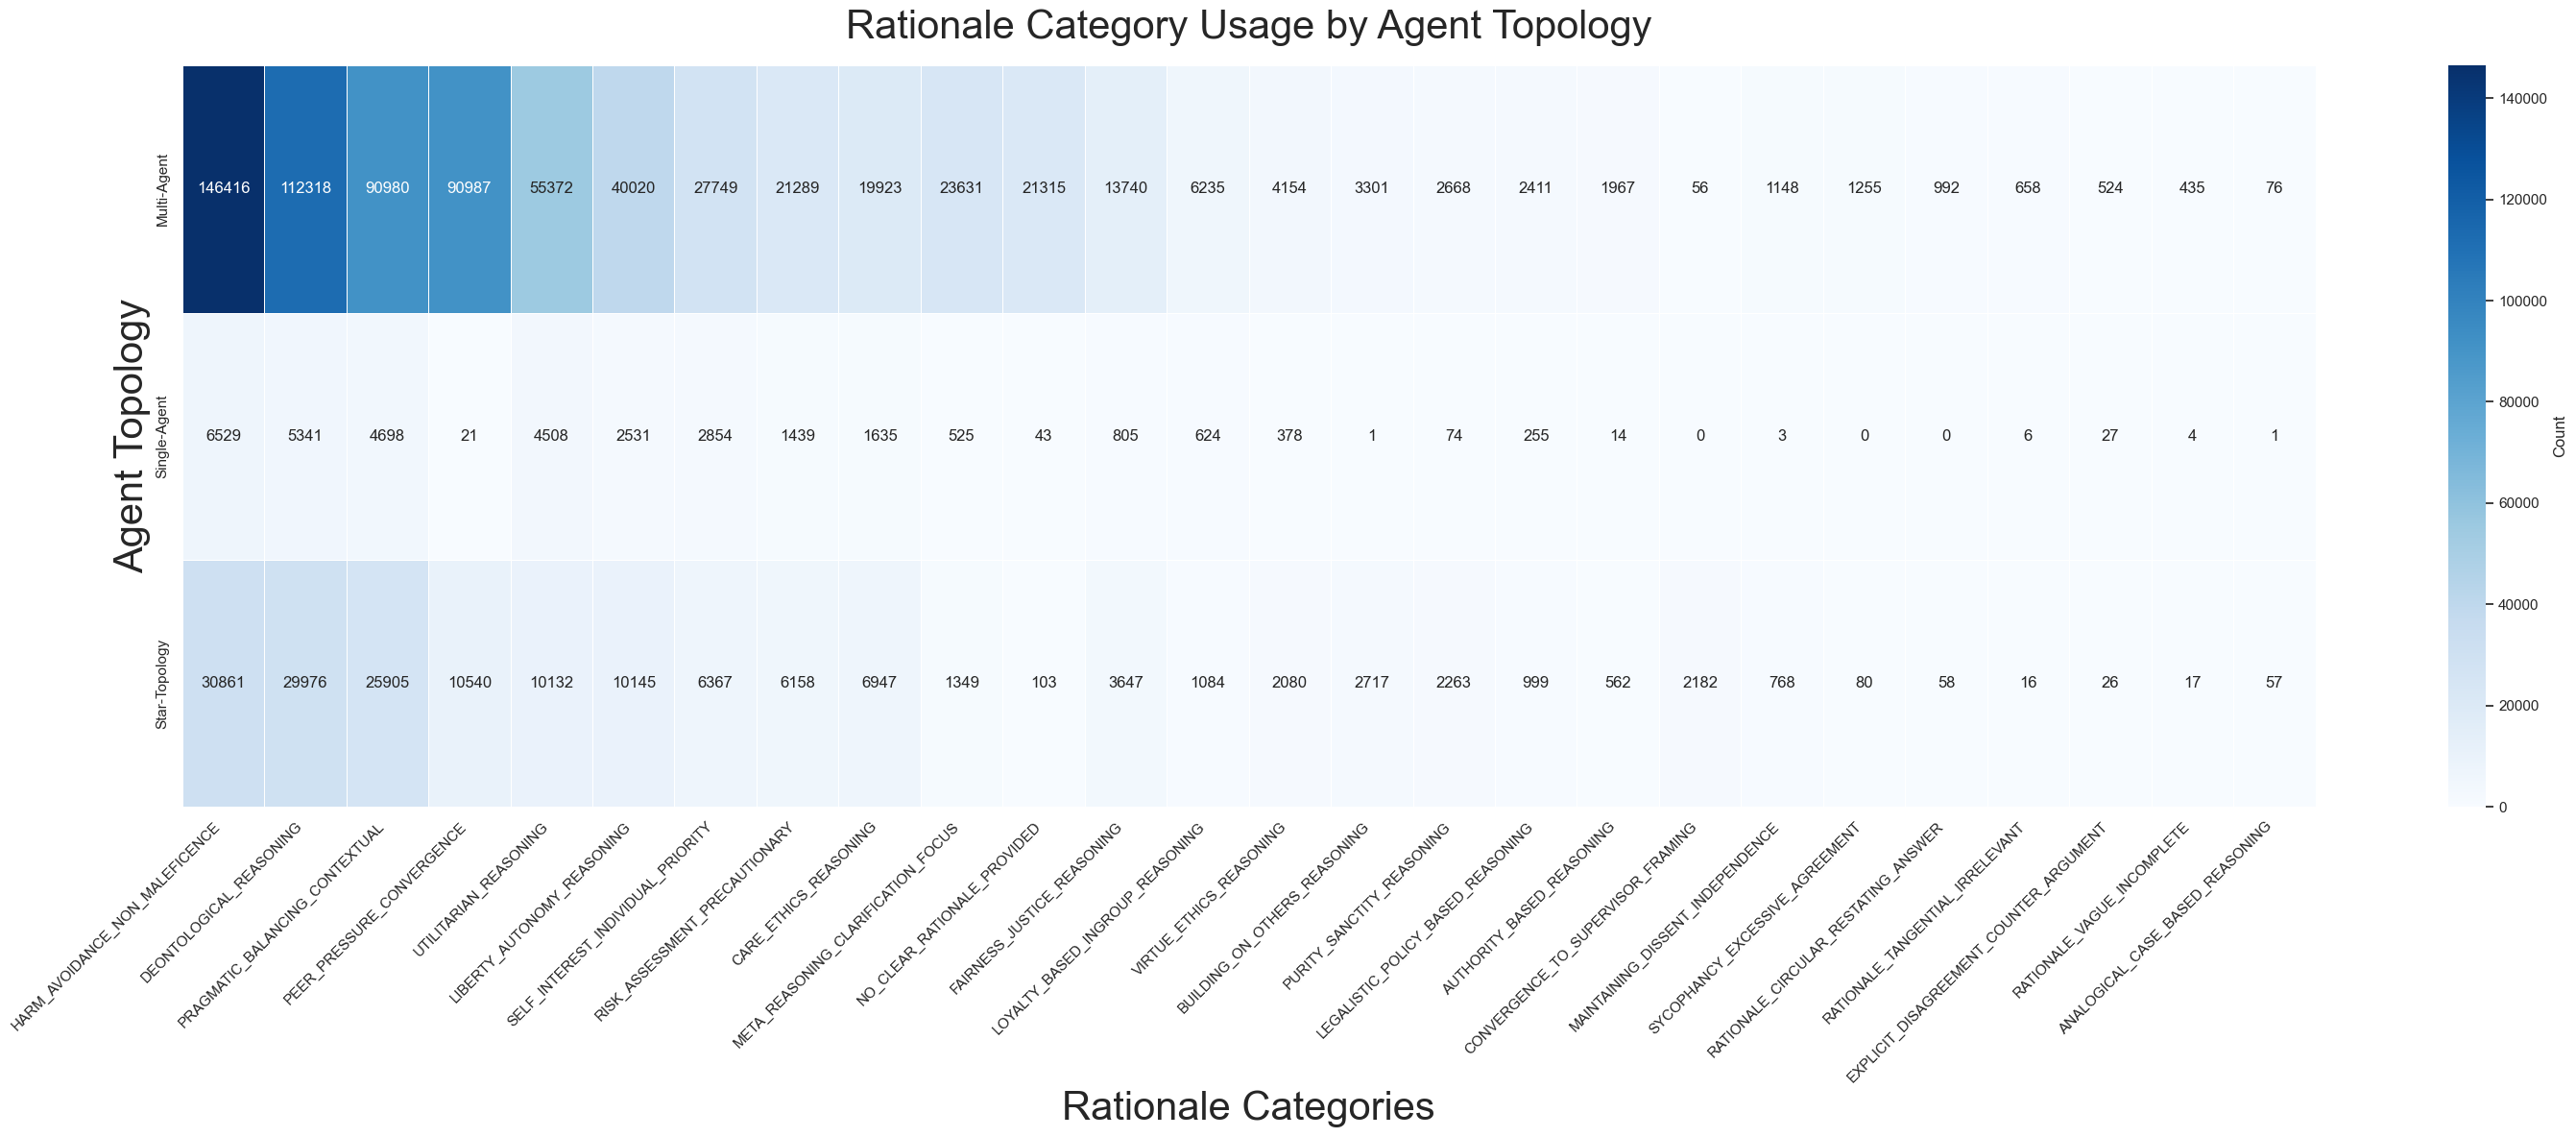


=== TOPOLOGY COMPARISON SUMMARY ===

Multi-Agent:
  Total category instances: 689620
  Top 3 categories: HARM_AVOIDANCE_NON_MALEFICENCE (146416), DEONTOLOGICAL_REASONING (112318), PEER_PRESSURE_CONVERGENCE (90987)

Single-Agent:
  Total category instances: 32316
  Top 3 categories: HARM_AVOIDANCE_NON_MALEFICENCE (6529), DEONTOLOGICAL_REASONING (5341), PRAGMATIC_BALANCING_CONTEXTUAL (4698)

Star-Topology:
  Total category instances: 155039
  Top 3 categories: HARM_AVOIDANCE_NON_MALEFICENCE (30861), DEONTOLOGICAL_REASONING (29976), PRAGMATIC_BALANCING_CONTEXTUAL (25905)

=== HEATMAP 2: DETAILED TOPOLOGY ANALYSIS (%) ===


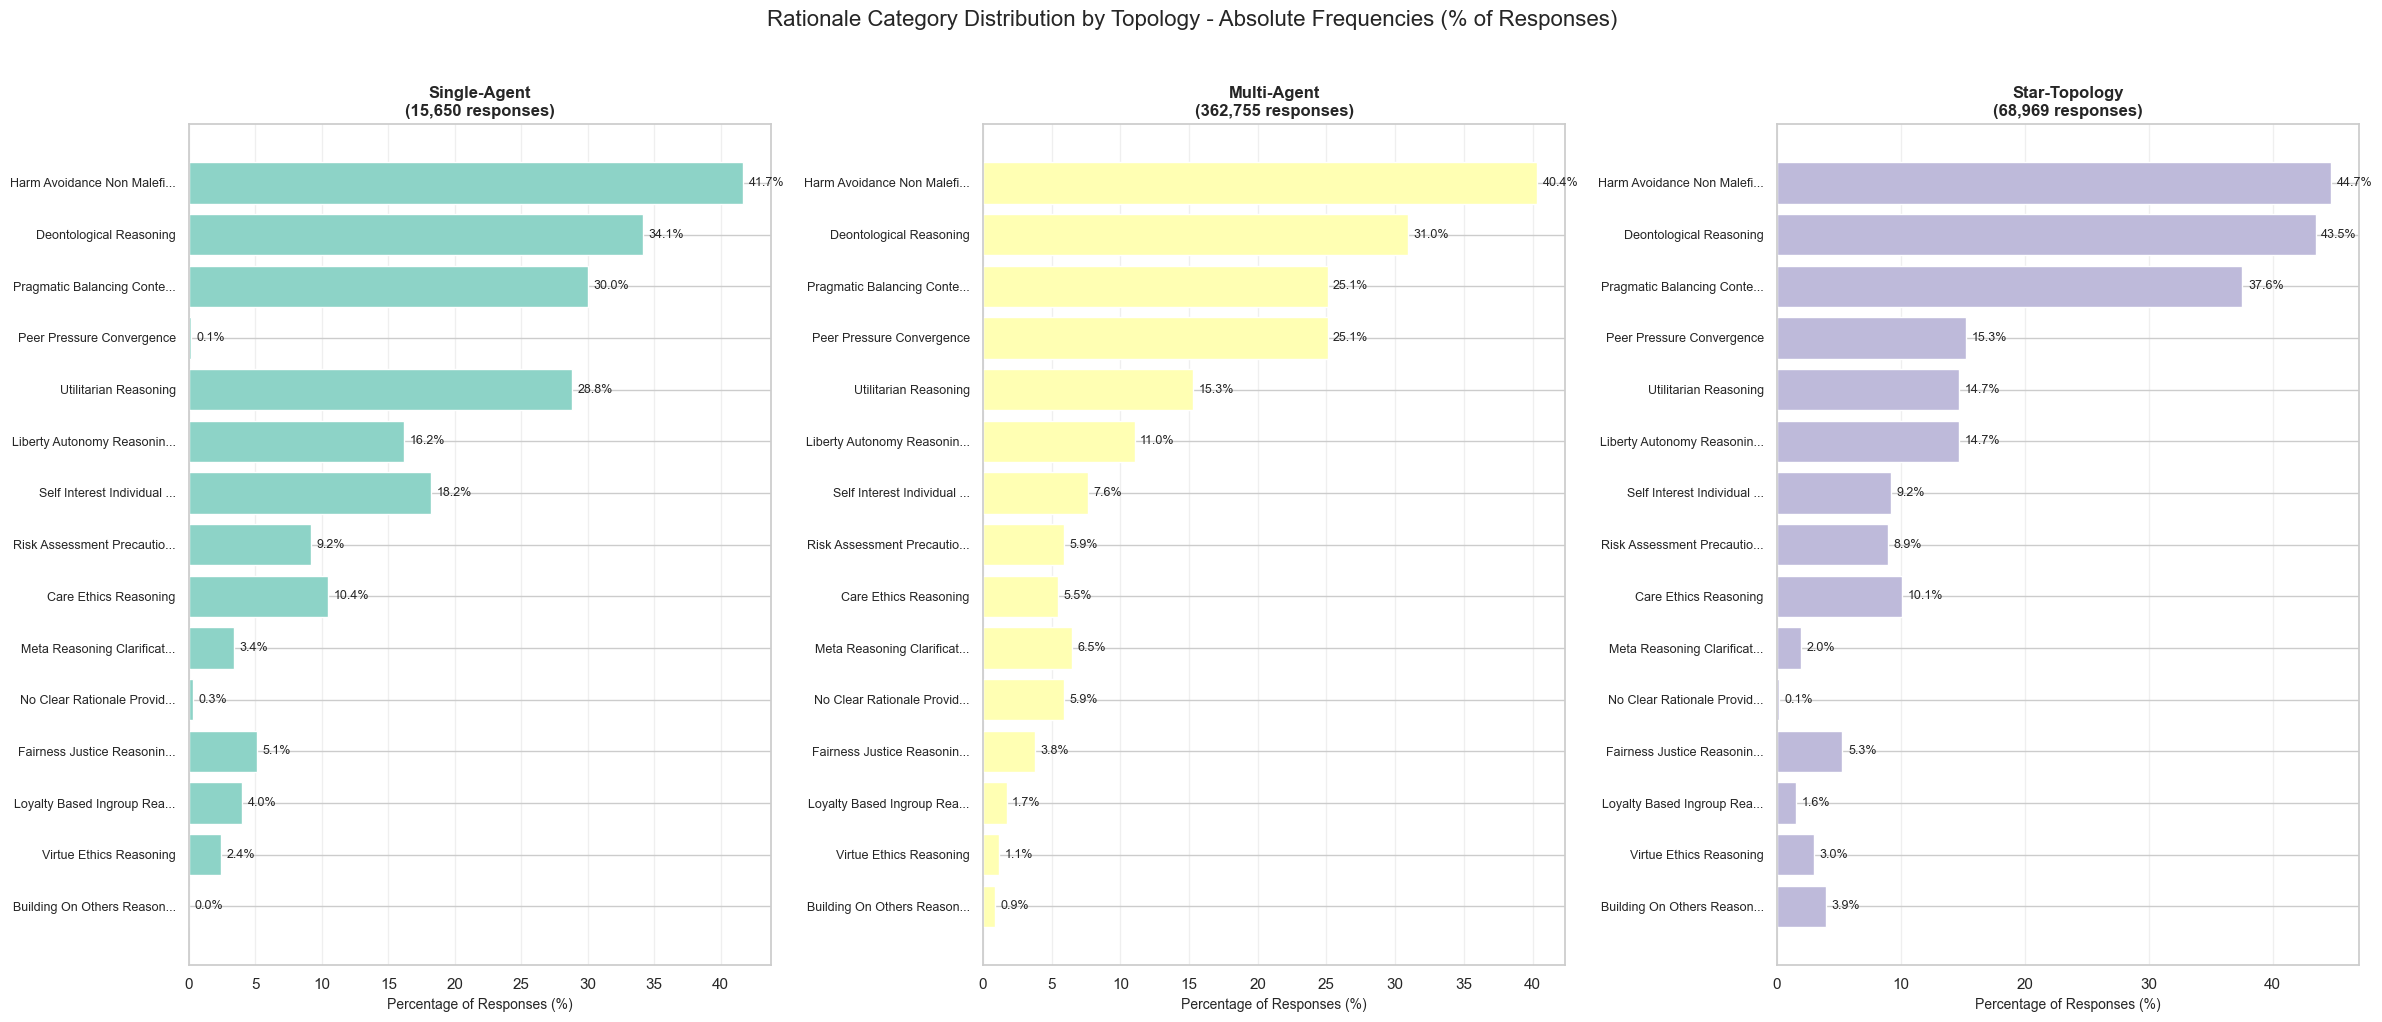

Question category information not available in the data.


In [6]:
# =============================================================================
# COMPREHENSIVE RATIONALE CLASSIFICATION ANALYSIS WITH ABSOLUTE FREQUENCIES
# =============================================================================
# Advanced analysis focusing specifically on rationale categories across different
# agent topologies and question categories - all heatmaps show absolute frequencies (%)

import glob, os, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from grade import RATIONALE_CATEGORIES

# Extract the list of valid/approved rationale category names
valid_cats = [c["name"] for c in RATIONALE_CATEGORIES]

# =============================================================================
# TOPOLOGY-SPECIFIC DATA LOADING
# =============================================================================
topologies = {
    "Single-Agent": os.path.join(BASE_DIR, "results"),
    "Multi-Agent": os.path.join(BASE_DIR, "results_multi"),
    "Star-Topology": os.path.join(BASE_DIR, "results_multi_star")
}

# =============================================================================
# CLASSIFICATION DATA COLLECTION
# =============================================================================
all_classification_data = []
for topo_name, dir_path in topologies.items():
    for fpath in glob.glob(os.path.join(dir_path, "*_classification.jsonl")):
        dfj = pd.read_json(fpath, lines=True)
        if "selected_categories" in dfj.columns:
            dfj['topology'] = topo_name
            all_classification_data.append(dfj)

# =============================================================================
# DATA PREPARATION FOR ANALYSIS
# =============================================================================
if all_classification_data:
    # Combine all classification data
    combined_df = pd.concat(all_classification_data, ignore_index=True)
    
    # Explode categories for individual category analysis
    exploded_df = combined_df.explode("selected_categories")
    exploded_df = exploded_df[exploded_df['selected_categories'].isin(valid_cats)]
    
    # Get question categories
    question_categories = sorted(exploded_df['category'].dropna().unique()) if 'category' in exploded_df.columns else ['All Questions']
    
    print(f"Found {len(question_categories)} question categories: {question_categories}")
    print(f"Found {len(topologies)} topologies: {list(topologies.keys())}")
    print(f"Total classification records: {len(combined_df)}")
    print(f"Valid rationale categories found: {len(exploded_df['selected_categories'].unique())}")
    
    # Calculate total responses per topology for absolute frequency calculations
    topology_response_totals = combined_df.groupby('topology').size()
    print(f"Response totals by topology: {dict(topology_response_totals)}")
    
    # =============================================================================
    # OVERVIEW HEATMAP: ALL TOPOLOGIES AND CATEGORIES
    # =============================================================================
    # Create a comprehensive heatmap showing rationale category usage patterns
    # across all agent topologies in a single visualization

    if not exploded_df.empty:
        # =============================================================================
        # DATA AGGREGATION FOR HEATMAP
        # =============================================================================
        # Group data to get usage counts
        topology_category_counts = exploded_df.groupby(['topology', 'selected_categories']).size().reset_index(name='count')
        
        # Create a pivot table suitable for heatmap visualization
        # Rows = topologies, Columns = rationale categories, Values = usage counts
        heatmap_data = topology_category_counts.pivot(
            index='topology', 
            columns='selected_categories', 
            values='count'
        ).fillna(0)  # Fill missing combinations with 0
        
        # =============================================================================
        # COLUMN ORDERING FOR BETTER VISUALIZATION
        # =============================================================================
        # Order columns by overall frequency to highlight most important categories
        col_order = exploded_df['selected_categories'].value_counts().index
        heatmap_data = heatmap_data[col_order]
        
        # =============================================================================
        # HEATMAP VISUALIZATION
        # =============================================================================
        # Create a large, detailed heatmap with annotations
        plt.figure(figsize=(30, 12))
        sns.heatmap(heatmap_data, 
                    annot=True,              # Show count values in each cell
                    fmt='g',                 # Format numbers without decimals
                    cmap='Blues',            # Blue color scheme (light to dark)
                    cbar_kws={'label': 'Count'},  # Label for color bar
                    linewidths=0.5)          # Add grid lines between cells
        
        # Customize the plot appearance
        plt.title('Rationale Category Usage by Agent Topology', fontsize=30, pad=20)
        plt.xlabel('Rationale Categories', fontsize=30)
        plt.ylabel('Agent Topology', fontsize=30)
        plt.xticks(rotation=45, ha='right')  # Rotate category labels for readability
        plt.tight_layout()  # Adjust spacing to prevent label cutoff
        plt.show()
        
        # =============================================================================
        # SUMMARY STATISTICS BY TOPOLOGY
        # =============================================================================
        # Provide quantitative summary of topology differences
        print("\n=== TOPOLOGY COMPARISON SUMMARY ===")
        for topology in heatmap_data.index:
            # Calculate total category instances for this topology
            total_categories = heatmap_data.loc[topology].sum()
            
            # Find the top 3 most used categories for this topology
            top_3_categories = heatmap_data.loc[topology].nlargest(3)
            
            print(f"\n{topology}:")
            print(f"  Total category instances: {int(total_categories)}")
            print(f"  Top 3 categories: {', '.join([f'{cat} ({int(count)})' for cat, count in top_3_categories.items()])}")
    else:
        print("No data available for topology comparison heatmap.")
    
    # =============================================================================
    # HEATMAP 2: INDIVIDUAL TOPOLOGY DETAILED ANALYSIS (ABSOLUTE FREQUENCIES)
    # =============================================================================
    if not exploded_df.empty:
        print("\n=== HEATMAP 2: DETAILED TOPOLOGY ANALYSIS (%) ===")
        
        # Get top 15 categories for consistent comparison
        top_categories = exploded_df['selected_categories'].value_counts().head(15).index.tolist()
        
        fig, axes = plt.subplots(1, 3, figsize=(24, 10))
        fig.suptitle('Rationale Category Distribution by Topology - Absolute Frequencies (% of Responses)', fontsize=16, y=1.02)
        
        for idx, (topo_name, ax) in enumerate(zip(topologies.keys(), axes)):
            # Get data for this topology
            topo_data = combined_df[combined_df['topology'] == topo_name]
            
            if not topo_data.empty:
                total_responses = len(topo_data)
                
                # Calculate absolute frequencies for this topology
                category_freqs = {}
                for cat in top_categories:
                    responses_with_cat = topo_data[topo_data['selected_categories'].apply(
                        lambda x: cat in x if isinstance(x, list) else False)].shape[0]
                    category_freqs[cat] = (responses_with_cat / total_responses) * 100
                
                # Convert to series and sort
                category_series = pd.Series(category_freqs)
                category_series = category_series.reindex(top_categories, fill_value=0)
                
                # Create horizontal bar chart
                y_pos = range(len(category_series))
                bars = ax.barh(y_pos, category_series.values, color=plt.cm.Set3(idx))
                
                # Add percentage labels on bars
                max_freq = max(category_series.values) if len(category_series.values) > 0 else 1
                for i, (bar, freq) in enumerate(zip(bars, category_series.values)):
                    if freq > 0:
                        ax.text(bar.get_width() + max_freq * 0.01,
                               bar.get_y() + bar.get_height()/2,
                               f'{freq:.1f}%',
                               va='center', ha='left', fontsize=9)
                
                # Formatting
                ax.set_yticks(y_pos)
                ax.set_yticklabels([cat.replace('_', ' ').title()[:25] + ('...' if len(cat) > 25 else '') 
                                   for cat in category_series.index], fontsize=9)
                ax.set_xlabel('Percentage of Responses (%)', fontsize=10)
                ax.set_title(f'{topo_name}\n({total_responses:,} responses)', fontsize=12, fontweight='bold')
                ax.grid(axis='x', alpha=0.3)
                ax.invert_yaxis()
            else:
                ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=12)
                ax.set_title(f'{topo_name}', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No data available for individual topology charts.")
    
    # =============================================================================
    # QUESTION CATEGORY ANALYSIS (if category data is available)
    # =============================================================================
    if not exploded_df.empty and 'category' in exploded_df.columns and len(question_categories) > 1:
        print(f"\n=== ANALYSIS BY QUESTION CATEGORY ===")
        
        # Create heatmaps for each question category across topologies
        n_categories = len(question_categories)
        n_topologies = len(topologies)
        
        # Calculate grid dimensions
        cols = min(3, n_categories)
        rows = (n_categories + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
        if n_categories == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle('Rationale Categories by Question Category and Topology', fontsize=16, y=1.02)
        
        for idx, q_category in enumerate(question_categories):
            row = idx // cols
            col = idx % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            
            # Filter data for this question category
            q_cat_data = exploded_df[exploded_df['category'] == q_category]
            
            if not q_cat_data.empty:
                # Create topology vs rationale category matrix
                category_topo_counts = q_cat_data.groupby(['topology', 'selected_categories']).size().reset_index(name='count')
                
                # Get top 10 categories for this question type
                top_rationale_cats = q_cat_data['selected_categories'].value_counts().head(10).index.tolist()
                
                # Create pivot table
                pivot_data = category_topo_counts.pivot(
                    index='topology', 
                    columns='selected_categories', 
                    values='count'
                ).fillna(0)
                
                # Filter to top categories only
                available_cats = [cat for cat in top_rationale_cats if cat in pivot_data.columns]
                if available_cats:
                    pivot_data = pivot_data[available_cats]
                    
                    # Create heatmap
                    sns.heatmap(pivot_data, 
                               annot=True, 
                               fmt='g', 
                               cmap='Blues',
                               ax=ax,
                               cbar=True,
                               linewidths=0.5)
                    ax.set_title(f'{q_category}', fontsize=11, fontweight='bold')
                    ax.set_xlabel('Rationale Category', fontsize=9)
                    ax.set_ylabel('Topology', fontsize=9)
                    ax.tick_params(axis='x', rotation=45, labelsize=8)
                    ax.tick_params(axis='y', rotation=0, labelsize=9)
                else:
                    ax.text(0.5, 0.5, f'No Data\n{q_category}', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=10)
                    ax.set_title(f'{q_category}', fontsize=11, fontweight='bold')
            else:
                ax.text(0.5, 0.5, f'No Data\n{q_category}', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=10)
                ax.set_title(f'{q_category}', fontsize=11, fontweight='bold')
        
        # Hide extra subplots
        for idx in range(n_categories, rows * cols):
            row = idx // cols
            col = idx % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            ax.set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Summary by question category
        print("\n=== QUESTION CATEGORY SUMMARY ===")
        for q_cat in question_categories:
            q_data = exploded_df[exploded_df['category'] == q_cat]
            if not q_data.empty:
                total_responses = len(q_data)
                top_category = q_data['selected_categories'].mode().iloc[0] if len(q_data) > 0 else "None"
                unique_categories = q_data['selected_categories'].nunique()
                print(f"\n{q_cat}:")
                print(f"  Total rationale instances: {total_responses}")
                print(f"  Unique rationale types: {unique_categories}")
                print(f"  Most common rationale: {top_category}")
                
                # Distribution across topologies
                topo_dist = q_data['topology'].value_counts()
                print(f"  Topology distribution: {dict(topo_dist)}")

    elif not exploded_df.empty:
        print("Question category information not available in the data.")
    else:
        print("No data available for question category analysis.")

In [17]:
# test code

exploded_df.head()


,question_id,agent_name,message_content,answer,confidence,model_name,run_index,is_response_off_topic,off_topic_reason,selected_categories,...,agent_model,topology,message_index,row_index,error_type,error_message,classification_item_dict,agent_responses_for_row_count,original_question,agent_responses_str_snippet
0,101,openai/gpt-4o-mini,Rationale Answer: The value of individual live...,6,6,openai/gpt-4o-mini,1.0,0.0,NaN,UTILITARIAN_REASONING,...,openai/gpt-4o-mini,Single-Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101,openai/gpt-4o-mini,Rationale Answer: The value of a child's life ...,7,7,openai/gpt-4o-mini,2.0,0.0,NaN,UTILITARIAN_REASONING,...,openai/gpt-4o-mini,Single-Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101,openai/gpt-4o-mini,Rationale Answer: The preservation of all huma...,7,7,openai/gpt-4o-mini,3.0,0.0,NaN,UTILITARIAN_REASONING,...,openai/gpt-4o-mini,Single-Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,101,openai/gpt-4o-mini,Rationale Answer: The moral value placed on in...,6,6,openai/gpt-4o-mini,4.0,0.0,NaN,DEONTOLOGICAL_REASONING,...,openai/gpt-4o-mini,Single-Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,101,openai/gpt-4o-mini,Rationale Answer: The moral value placed on in...,6,6,openai/gpt-4o-mini,4.0,0.0,NaN,CARE_ETHICS_REASONING,...,openai/gpt-4o-mini,Single-Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# get columns
exploded_df['selected_categories']

0                  UTILITARIAN_REASONING
1                  UTILITARIAN_REASONING
2                  UTILITARIAN_REASONING
3                DEONTOLOGICAL_REASONING
3                  CARE_ETHICS_REASONING
                       ...              
447372        LIBERTY_AUTONOMY_REASONING
447372           DEONTOLOGICAL_REASONING
447373    HARM_AVOIDANCE_NON_MALEFICENCE
447373        LIBERTY_AUTONOMY_REASONING
447373           DEONTOLOGICAL_REASONING
Name: selected_categories, Length: 876975, dtype: object

In [20]:
combined_df['selected_categories']

0                                   [UTILITARIAN_REASONING]
1                                   [UTILITARIAN_REASONING]
2                                   [UTILITARIAN_REASONING]
3          [DEONTOLOGICAL_REASONING, CARE_ETHICS_REASONING]
4         [DEONTOLOGICAL_REASONING, META_REASONING_CLARI...
                                ...                        
447369    [HARM_AVOIDANCE_NON_MALEFICENCE, LIBERTY_AUTON...
447370    [HARM_AVOIDANCE_NON_MALEFICENCE, LIBERTY_AUTON...
447371    [HARM_AVOIDANCE_NON_MALEFICENCE, LIBERTY_AUTON...
447372    [HARM_AVOIDANCE_NON_MALEFICENCE, LIBERTY_AUTON...
447373    [HARM_AVOIDANCE_NON_MALEFICENCE, LIBERTY_AUTON...
Name: selected_categories, Length: 447374, dtype: object

In [7]:
# =============================================================================
# QUESTION CATEGORY HEATMAPS: ANALYZE RATIONALE USAGE BY QUESTION TYPE
# =============================================================================
# Create heatmaps showing how rationale categories vary by question category
# across different topologies

if not exploded_df.empty and 'category' in exploded_df.columns:
    print("\n=== QUESTION CATEGORY ANALYSIS ===")
    
    # Get unique question categories
    question_cats = exploded_df['category'].dropna().unique()
    
    if len(question_cats) > 1:
        print(f"Found {len(question_cats)} question categories: {list(question_cats)}")
        
        # =============================================================================
        # HEATMAP 1: RATIONALE CATEGORIES BY QUESTION CATEGORY (ALL TOPOLOGIES)
        # =============================================================================
        print("\n1. Overall Rationale Usage by Question Category")
        
        # Get top 12 rationale categories overall
        top_12_rationale = exploded_df['selected_categories'].value_counts().head(12).index.tolist()
        
        # Create question category vs rationale category matrix
        question_rationale_counts = exploded_df.groupby(['category', 'selected_categories']).size().reset_index(name='count')
        question_rationale_pivot = question_rationale_counts.pivot(
            index='category', 
            columns='selected_categories', 
            values='count'
        ).fillna(0)
        
        # Filter to top rationale categories
        available_rationale_cats = [cat for cat in top_12_rationale if cat in question_rationale_pivot.columns]
        if available_rationale_cats:
            question_rationale_pivot = question_rationale_pivot[available_rationale_cats]
            
            plt.figure(figsize=(14, 6))
            sns.heatmap(question_rationale_pivot, 
                       annot=True, 
                       fmt='g', 
                       cmap='viridis',
                       cbar_kws={'label': 'Usage Count'},
                       linewidths=0.5)
            plt.title('Rationale Category Usage by Question Category (All Topologies)', fontsize=14, pad=20)
            plt.xlabel('Rationale Categories', fontsize=12)
            plt.ylabel('Question Categories', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
        
        # =============================================================================
        # HEATMAP 2: QUESTION CATEGORY VS TOPOLOGY INTERACTION
        # =============================================================================
        print("\n2. Question Category Distribution Across Topologies")
        
        # Create question category vs topology matrix
        question_topology_counts = exploded_df.groupby(['category', 'topology']).size().reset_index(name='count')
        question_topology_pivot = question_topology_counts.pivot(
            index='category', 
            columns='topology', 
            values='count'
        ).fillna(0)
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(question_topology_pivot, 
                   annot=True, 
                   fmt='g', 
                   cmap='plasma',
                   cbar_kws={'label': 'Response Count'},
                   linewidths=0.5)
        plt.title('Question Category Distribution Across Topologies', fontsize=14, pad=20)
        plt.xlabel('Topology', fontsize=12)
        plt.ylabel('Question Categories', fontsize=12)
        plt.xticks(rotation=0)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # =============================================================================
        # HEATMAP 3: DETAILED BREAKDOWN BY QUESTION CATEGORY AND TOPOLOGY
        # =============================================================================
        print("\n3. Detailed Rationale Usage by Question Category and Topology")
        
        # Create separate heatmaps for each question category
        n_question_cats = len(question_cats)
        cols = min(2, n_question_cats)
        rows = (n_question_cats + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(12 * cols, 6 * rows))
        if n_question_cats == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle('Top Rationale Categories by Question Category and Topology', fontsize=16, y=1.02)
        
        for idx, q_cat in enumerate(question_cats):
            row = idx // cols
            col = idx % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            
            # Filter data for this question category
            q_cat_data = exploded_df[exploded_df['category'] == q_cat]
            
            if not q_cat_data.empty:
                # Get top 8 rationale categories for this question type
                top_8_for_qcat = q_cat_data['selected_categories'].value_counts().head(8).index.tolist()
                
                # Create topology vs rationale category matrix for this question category
                qcat_topo_rationale = q_cat_data.groupby(['topology', 'selected_categories']).size().reset_index(name='count')
                qcat_pivot = qcat_topo_rationale.pivot(
                    index='topology', 
                    columns='selected_categories', 
                    values='count'
                ).fillna(0)
                
                # Filter to top categories for this question type
                available_qcat_rationale = [cat for cat in top_8_for_qcat if cat in qcat_pivot.columns]
                if available_qcat_rationale:
                    qcat_pivot = qcat_pivot[available_qcat_rationale]
                    
                    sns.heatmap(qcat_pivot, 
                               annot=True, 
                               fmt='g', 
                               cmap='coolwarm',
                               ax=ax,
                               cbar=True,
                               linewidths=0.5)
                    ax.set_title(f'{q_cat}', fontsize=12, fontweight='bold')
                    ax.set_xlabel('Rationale Category', fontsize=10)
                    ax.set_ylabel('Topology', fontsize=10)
                    ax.tick_params(axis='x', rotation=45, labelsize=8)
                    ax.tick_params(axis='y', rotation=0, labelsize=9)
                else:
                    ax.text(0.5, 0.5, f'No Data\n{q_cat}', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=12)
                    ax.set_title(f'{q_cat}', fontsize=12, fontweight='bold')
            else:
                ax.text(0.5, 0.5, f'No Data\n{q_cat}', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=12)
                ax.set_title(f'{q_cat}', fontsize=12, fontweight='bold')
        
        # Hide extra subplots
        for idx in range(n_question_cats, rows * cols):
            row = idx // cols
            col = idx % cols
            ax = axes[row, col] if rows > 1 else axes[col]
            ax.set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # =============================================================================
        # SUMMARY STATISTICS BY QUESTION CATEGORY
        # =============================================================================
        print("\n=== QUESTION CATEGORY SUMMARY STATISTICS ===")
        
        for q_cat in question_cats:
            q_data = exploded_df[exploded_df['category'] == q_cat]
            if not q_data.empty:
                total_responses = len(q_data)
                unique_rationales = q_data['selected_categories'].nunique()
                top_rationale = q_data['selected_categories'].mode().iloc[0] if len(q_data) > 0 else "None"
                
                print(f"\n{q_cat}:")
                print(f"  Total rationale instances: {total_responses:,}")
                print(f"  Unique rationale types: {unique_rationales}")
                print(f"  Most common rationale: {top_rationale}")
    
    else:
        print(f"Only one question category found: {question_cats[0] if question_cats else 'None'}")
        print("Skipping question category analysis.")

elif 'category' not in exploded_df.columns:
    print("No question category data available in the dataset.")
else:
    print("No data available for question category analysis.")

No question category data available in the dataset.


In [8]:
# =============================================================================
# HEATMAPS 3-4: QUESTION CATEGORY ANALYSIS (ABSOLUTE FREQUENCIES)
# =============================================================================
if not exploded_df.empty and 'category' in exploded_df.columns and len(question_categories) > 1:
    print(f"\n=== HEATMAPS 3-4: QUESTION CATEGORY ANALYSIS (%) ===")
    
    # HEATMAP 3: Overall question category vs rationale category (absolute frequencies)
    print("\n3. Overall Rationale Usage by Question Category (%)")
    
    # Calculate absolute frequencies by question category
    question_response_totals = combined_df.groupby('category').size()
    
    question_cat_freqs = []
    for q_cat in question_categories:
        q_cat_data = combined_df[combined_df['category'] == q_cat]
        total_responses = len(q_cat_data)
        
        if total_responses > 0:
            for cat in valid_cats:
                responses_with_cat = q_cat_data[q_cat_data['selected_categories'].apply(
                    lambda x: cat in x if isinstance(x, list) else False)].shape[0]
                if responses_with_cat > 0:
                    question_cat_freqs.append({
                        'category': q_cat,
                        'selected_categories': cat,
                        'absolute_freq': (responses_with_cat / total_responses) * 100
                    })
    
    if question_cat_freqs:
        question_freq_df = pd.DataFrame(question_cat_freqs)
        
        # Get top 12 rationale categories for question analysis
        top_12_rationale = exploded_df['selected_categories'].value_counts().head(12).index.tolist()
        
        # Create pivot table
        filtered_q_data = question_freq_df[question_freq_df['selected_categories'].isin(top_12_rationale)]
        question_freq_pivot = filtered_q_data.pivot(
            index='category', 
            columns='selected_categories', 
            values='absolute_freq'
        ).fillna(0)
        
        if not question_freq_pivot.empty:
            plt.figure(figsize=(16, 8))
            sns.heatmap(question_freq_pivot, 
                       annot=True, 
                       fmt='.1f', 
                       cmap='viridis',
                       cbar_kws={'label': 'Percentage of Responses (%)'},
                       linewidths=0.5)
            plt.title('Rationale Category Usage by Question Category (% of Responses)', fontsize=14, pad=20)
            plt.xlabel('Rationale Categories', fontsize=12)
            plt.ylabel('Question Categories', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
    
    # HEATMAP 4: Question category distribution across topologies
    print("\n4. Question Category Distribution Across Topologies (%)")
    
    # Calculate what percentage of each topology's responses belong to each question category
    topo_question_freqs = []
    for topo in combined_df['topology'].unique():
        topo_data = combined_df[combined_df['topology'] == topo]
        total_responses = len(topo_data)
        
        for q_cat in question_categories:
            q_cat_responses = len(topo_data[topo_data['category'] == q_cat])
            if q_cat_responses > 0:
                topo_question_freqs.append({
                    'topology': topo,
                    'category': q_cat,
                    'absolute_freq': (q_cat_responses / total_responses) * 100
                })
    
    if topo_question_freqs:
        topo_question_df = pd.DataFrame(topo_question_freqs)
        topo_question_pivot = topo_question_df.pivot(
            index='category', 
            columns='topology', 
            values='absolute_freq'
        ).fillna(0)
        
        plt.figure(figsize=(12, 6))
        sns.heatmap(topo_question_pivot, 
                   annot=True, 
                   fmt='.1f', 
                   cmap='plasma',
                   cbar_kws={'label': 'Percentage of Topology Responses (%)'},
                   linewidths=0.5)
        plt.title('Question Category Distribution Across Topologies (% of Each Topology)', fontsize=14, pad=20)
        plt.xlabel('Topology', fontsize=12)
        plt.ylabel('Question Categories', fontsize=12)
        plt.xticks(rotation=0)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

elif 'category' not in exploded_df.columns:
    print("No question category data available in the dataset.")
else:
    print(f"Only one question category found: {question_categories[0] if question_categories else 'None'}")

No question category data available in the dataset.


In [9]:
exploded_df.head()

,question_id,agent_name,message_content,answer,confidence,model_name,run_index,is_response_off_topic,off_topic_reason,selected_categories,...,agent_model,topology,message_index,row_index,error_type,error_message,classification_item_dict,agent_responses_for_row_count,original_question,agent_responses_str_snippet
0,101,openai/gpt-4o-mini,Rationale Answer: The value of individual live...,6,6,openai/gpt-4o-mini,1.0,0.0,NaN,UTILITARIAN_REASONING,...,openai/gpt-4o-mini,Single-Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101,openai/gpt-4o-mini,Rationale Answer: The value of a child's life ...,7,7,openai/gpt-4o-mini,2.0,0.0,NaN,UTILITARIAN_REASONING,...,openai/gpt-4o-mini,Single-Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101,openai/gpt-4o-mini,Rationale Answer: The preservation of all huma...,7,7,openai/gpt-4o-mini,3.0,0.0,NaN,UTILITARIAN_REASONING,...,openai/gpt-4o-mini,Single-Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,101,openai/gpt-4o-mini,Rationale Answer: The moral value placed on in...,6,6,openai/gpt-4o-mini,4.0,0.0,NaN,DEONTOLOGICAL_REASONING,...,openai/gpt-4o-mini,Single-Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,101,openai/gpt-4o-mini,Rationale Answer: The moral value placed on in...,6,6,openai/gpt-4o-mini,4.0,0.0,NaN,CARE_ETHICS_REASONING,...,openai/gpt-4o-mini,Single-Agent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



=== HEATMAPS 5-7: AGENT-SPECIFIC CATEGORY ANALYSIS (%) ===

5. Single-Agent Category Usage by Model (%)


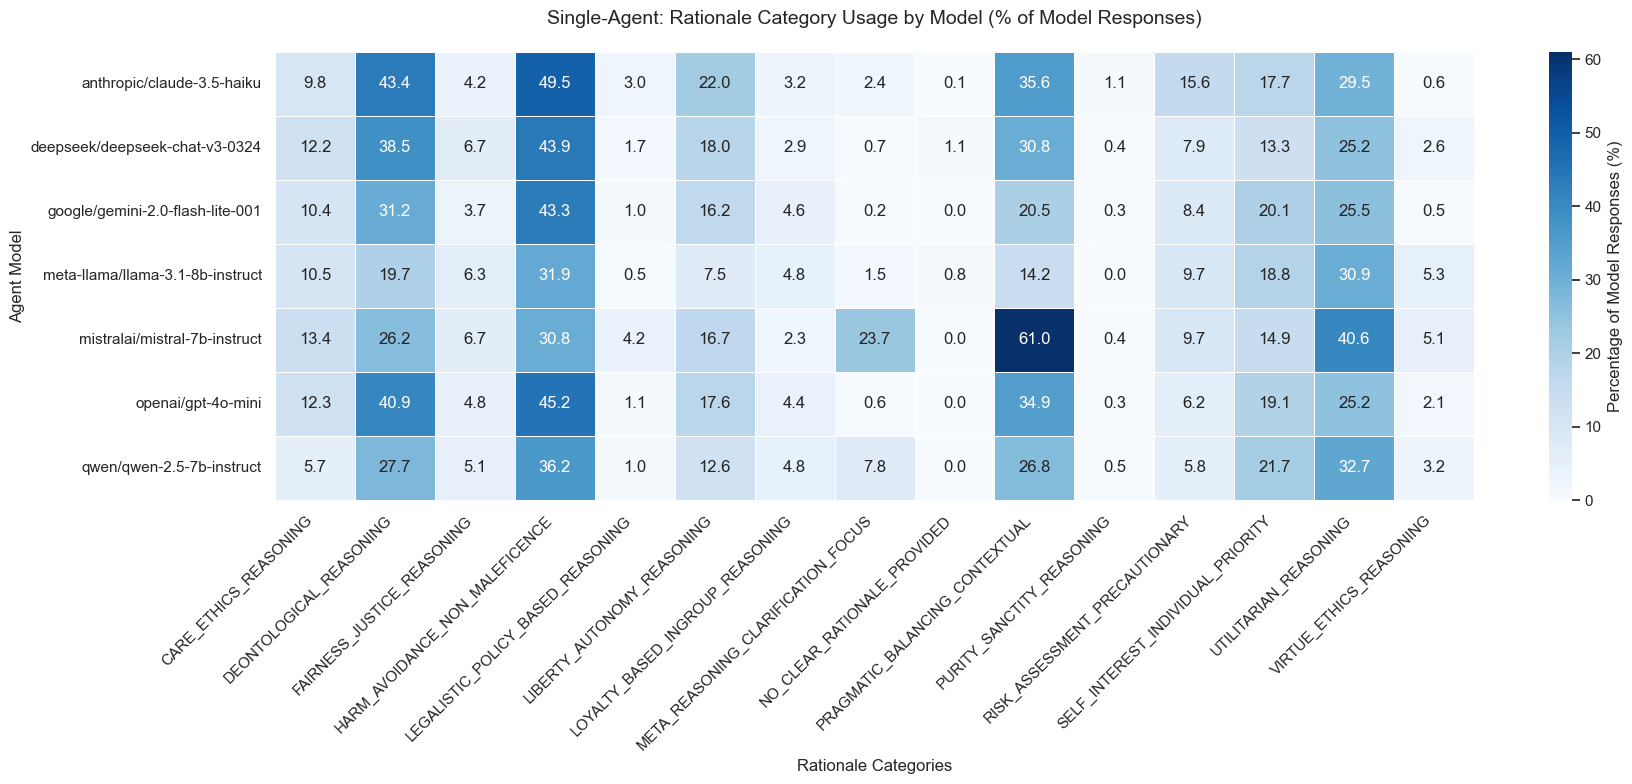


6. Multi-Agent Category Usage by Model (%)


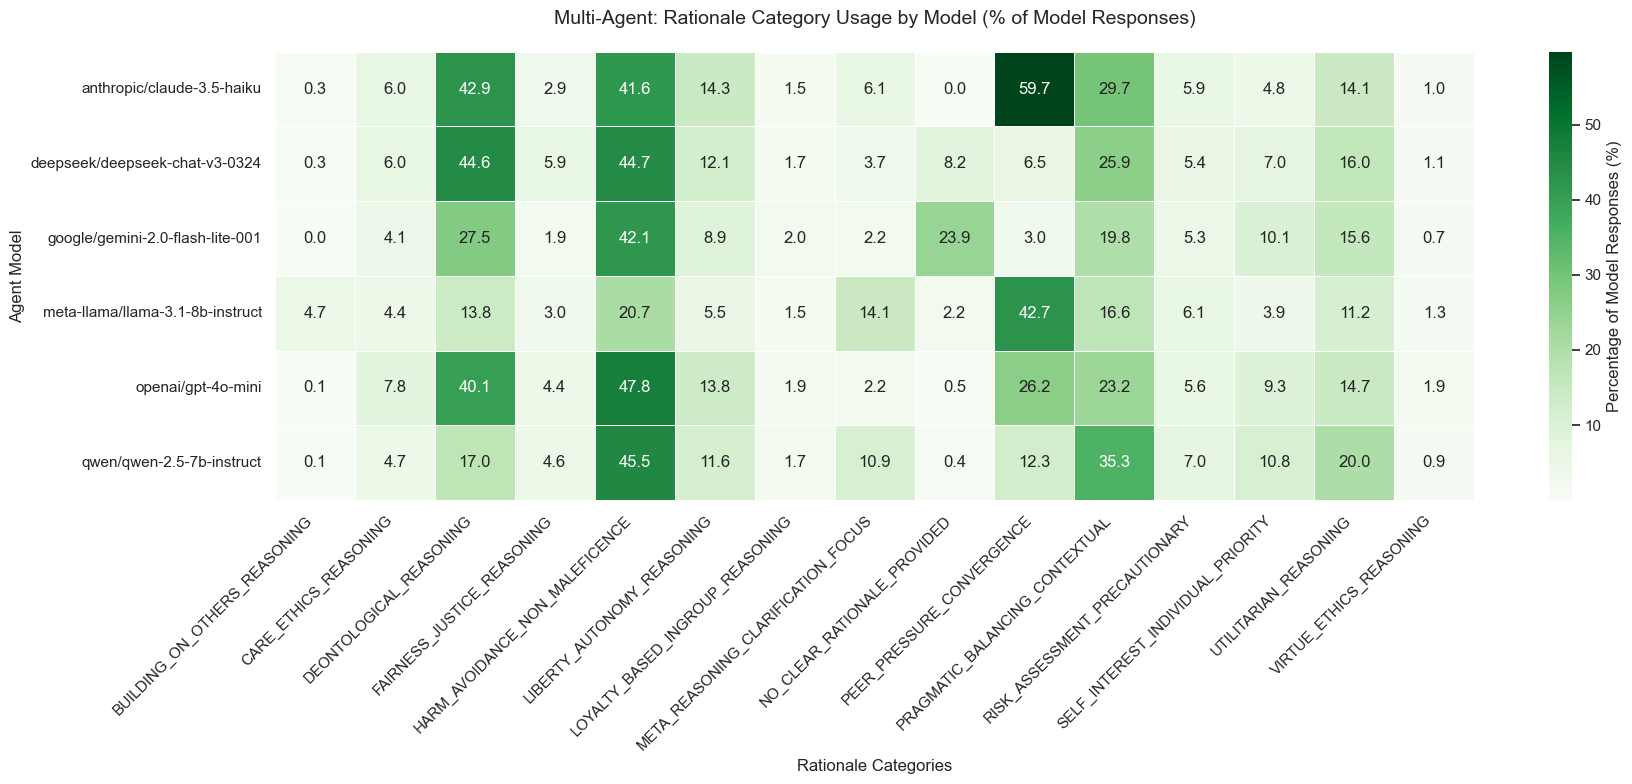


7. Star-Topology Category Usage by Model (%)


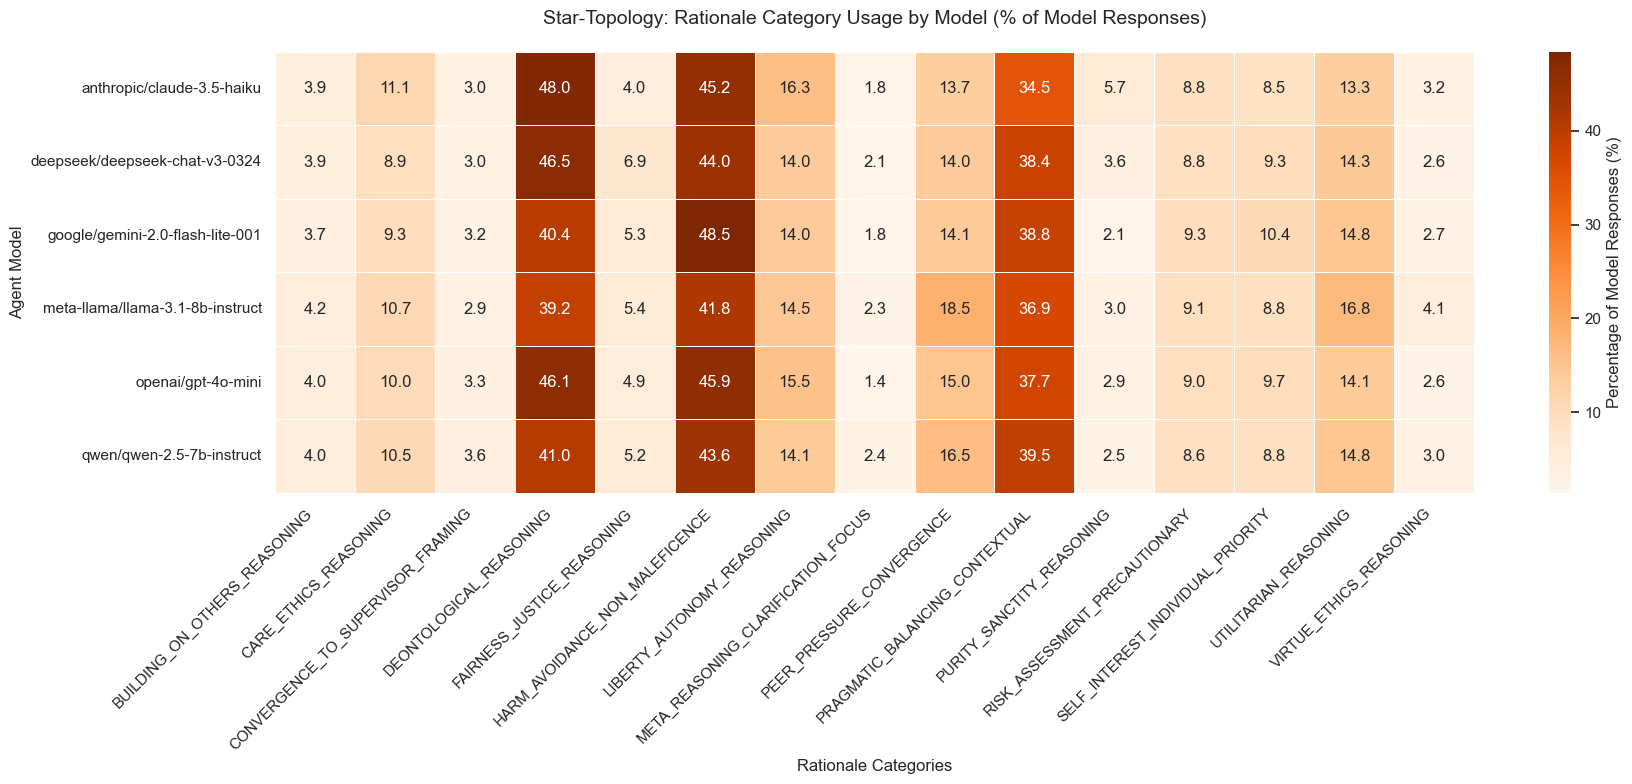

In [10]:
# =============================================================================
# HEATMAPS 5-7: AGENT-SPECIFIC ANALYSIS (ABSOLUTE FREQUENCIES)
# =============================================================================
if not exploded_df.empty and 'agent_model' in exploded_df.columns:
    print("\n=== HEATMAPS 5-7: AGENT-SPECIFIC CATEGORY ANALYSIS (%) ===")
    
    # HEATMAP 5: Single-Agent Category Usage by Model
    single_agent_data = combined_df[combined_df['topology'] == 'Single-Agent']
    
    if not single_agent_data.empty:
        print("\n5. Single-Agent Category Usage by Model (%)")
        
        # Calculate absolute frequencies for single agents
        single_agent_freqs = []
        for model in single_agent_data['agent_model'].unique():
            model_data = single_agent_data[single_agent_data['agent_model'] == model]
            total_responses = len(model_data)
            
            for cat in valid_cats:
                responses_with_cat = model_data[model_data['selected_categories'].apply(
                    lambda x: cat in x if isinstance(x, list) else False)].shape[0]
                if responses_with_cat > 0:
                    single_agent_freqs.append({
                        'agent_model': model,
                        'selected_categories': cat,
                        'absolute_freq': (responses_with_cat / total_responses) * 100
                    })
        
        if single_agent_freqs:
            single_freq_df = pd.DataFrame(single_agent_freqs)
            top_15_single = exploded_df[exploded_df['topology'] == 'Single-Agent']['selected_categories'].value_counts().head(15).index.tolist()
            
            filtered_single = single_freq_df[single_freq_df['selected_categories'].isin(top_15_single)]
            single_freq_pivot = filtered_single.pivot(
                index='agent_model', 
                columns='selected_categories', 
                values='absolute_freq'
            ).fillna(0)
            
            if not single_freq_pivot.empty:
                plt.figure(figsize=(18, 8))
                sns.heatmap(single_freq_pivot, 
                           annot=True, 
                           fmt='.1f', 
                           cmap='Blues',
                           cbar_kws={'label': 'Percentage of Model Responses (%)'},
                           linewidths=0.5)
                plt.title('Single-Agent: Rationale Category Usage by Model (% of Model Responses)', fontsize=14, pad=20)
                plt.xlabel('Rationale Categories', fontsize=12)
                plt.ylabel('Agent Model', fontsize=12)
                plt.xticks(rotation=45, ha='right')
                plt.yticks(rotation=0)
                plt.tight_layout()
                plt.show()
    
    # HEATMAP 6: Multi-Agent Category Usage by Model
    multi_agent_data = combined_df[combined_df['topology'] == 'Multi-Agent']
    
    if not multi_agent_data.empty:
        print("\n6. Multi-Agent Category Usage by Model (%)")
        
        # Calculate absolute frequencies for multi-agent
        multi_agent_freqs = []
        for model in multi_agent_data['agent_model'].unique():
            model_data = multi_agent_data[multi_agent_data['agent_model'] == model]
            total_responses = len(model_data)
            
            for cat in valid_cats:
                responses_with_cat = model_data[model_data['selected_categories'].apply(
                    lambda x: cat in x if isinstance(x, list) else False)].shape[0]
                if responses_with_cat > 0:
                    multi_agent_freqs.append({
                        'agent_model': model,
                        'selected_categories': cat,
                        'absolute_freq': (responses_with_cat / total_responses) * 100
                    })
        
        if multi_agent_freqs:
            multi_freq_df = pd.DataFrame(multi_agent_freqs)
            top_15_multi = exploded_df[exploded_df['topology'] == 'Multi-Agent']['selected_categories'].value_counts().head(15).index.tolist()
            
            filtered_multi = multi_freq_df[multi_freq_df['selected_categories'].isin(top_15_multi)]
            multi_freq_pivot = filtered_multi.pivot(
                index='agent_model', 
                columns='selected_categories', 
                values='absolute_freq'
            ).fillna(0)
            
            if not multi_freq_pivot.empty:
                plt.figure(figsize=(18, 8))
                sns.heatmap(multi_freq_pivot, 
                           annot=True, 
                           fmt='.1f', 
                           cmap='Greens',
                           cbar_kws={'label': 'Percentage of Model Responses (%)'},
                           linewidths=0.5)
                plt.title('Multi-Agent: Rationale Category Usage by Model (% of Model Responses)', fontsize=14, pad=20)
                plt.xlabel('Rationale Categories', fontsize=12)
                plt.ylabel('Agent Model', fontsize=12)
                plt.xticks(rotation=45, ha='right')
                plt.yticks(rotation=0)
                plt.tight_layout()
                plt.show()
    
    # HEATMAP 7: Star Topology Category Usage by Model
    star_data = combined_df[combined_df['topology'] == 'Star-Topology']
    
    if not star_data.empty:
        print("\n7. Star-Topology Category Usage by Model (%)")
        
        # Calculate absolute frequencies for star topology
        star_freqs = []
        for model in star_data['agent_model'].unique():
            model_data = star_data[star_data['agent_model'] == model]
            total_responses = len(model_data)
            
            for cat in valid_cats:
                responses_with_cat = model_data[model_data['selected_categories'].apply(
                    lambda x: cat in x if isinstance(x, list) else False)].shape[0]
                if responses_with_cat > 0:
                    star_freqs.append({
                        'agent_model': model,
                        'selected_categories': cat,
                        'absolute_freq': (responses_with_cat / total_responses) * 100
                    })
        
        if star_freqs:
            star_freq_df = pd.DataFrame(star_freqs)
            top_15_star = exploded_df[exploded_df['topology'] == 'Star-Topology']['selected_categories'].value_counts().head(15).index.tolist()
            
            filtered_star = star_freq_df[star_freq_df['selected_categories'].isin(top_15_star)]
            star_freq_pivot = filtered_star.pivot(
                index='agent_model', 
                columns='selected_categories', 
                values='absolute_freq'
            ).fillna(0)
            
            if not star_freq_pivot.empty:
                plt.figure(figsize=(18, 8))
                sns.heatmap(star_freq_pivot, 
                           annot=True, 
                           fmt='.1f', 
                           cmap='Oranges',
                           cbar_kws={'label': 'Percentage of Model Responses (%)'},
                           linewidths=0.5)
                plt.title('Star-Topology: Rationale Category Usage by Model (% of Model Responses)', fontsize=14, pad=20)
                plt.xlabel('Rationale Categories', fontsize=12)
                plt.ylabel('Agent Model', fontsize=12)
                plt.xticks(rotation=45, ha='right')
                plt.yticks(rotation=0)
                plt.tight_layout()
                plt.show()

else:
    print("No agent model data available for agent-specific analysis.")